In [61]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
# Импорт библиотек

In [62]:
# Загрузка данных
data = pd.read_csv('data/root_cause_analysis.csv')
data

,ID,CPU_LOAD,MEMORY_LOAD,DELAY,ERROR_1000,ERROR_1001,ERROR_1002,ERROR_1003,ROOT_CAUSE
0,1,0,0,0,0,1,0,1,MEMORY
1,2,0,0,0,0,0,0,1,MEMORY
2,3,0,1,1,0,0,1,1,MEMORY
3,4,0,1,0,1,1,0,1,MEMORY
4,5,1,1,0,1,0,1,0,NETWORK_DELAY
...,...,...,...,...,...,...,...,...,...
995,996,0,0,0,0,0,0,1,DATABASE_ISSUE
996,997,0,0,0,1,0,0,0,NETWORK_DELAY
997,998,1,1,1,0,0,0,0,MEMORY
998,999,0,1,1,1,1,0,0,NETWORK_DELAY


In [63]:
print(f'Количество строк исходных данных: {data.shape[0]}\nКоличество столбцов исходных данных: {data.shape[1]}')

Количество строк исходных данных: 1000
Количество столбцов исходных данных: 9


In [64]:
data.isna().sum()

ID             0
CPU_LOAD       0
MEMORY_LOAD    0
DELAY          0
ERROR_1000     0
ERROR_1001     0
ERROR_1002     0
ERROR_1003     0
ROOT_CAUSE     0
dtype: int64

In [65]:
data.dtypes

ID              int64
CPU_LOAD        int64
MEMORY_LOAD     int64
DELAY           int64
ERROR_1000      int64
ERROR_1001      int64
ERROR_1002      int64
ERROR_1003      int64
ROOT_CAUSE     object
dtype: object

**ID** - Уникальный номер процесса

**CPU_LOAD** - Информирует об использовании центального процессора в конкретном процессе

**MEMORY_LOAD** - Информирует об использовании оперативной памяти в конкретном процессе

**DELAY** - Информирует о налачии задержки в конкретном процессе

**ERROR_1000** - Информирует об утечке памяти Internet Explorer

**ERROR_1001** - Информирует об ошибке чтения данных или об ошибке вывода

**ERROR_1002** - Информирует об ошибке подключения к интернету

**ERROR_1003** - Информирует об утечке памяти внутри системы

**ROOT_CAUSE** - Определяет, что стало первопричиной вышеуказанных ошибок

Accuracy: 0.855
Precision: 0.858344579397211
Recall: 0.8541666666666666
F1-score: 0.8548820125141479


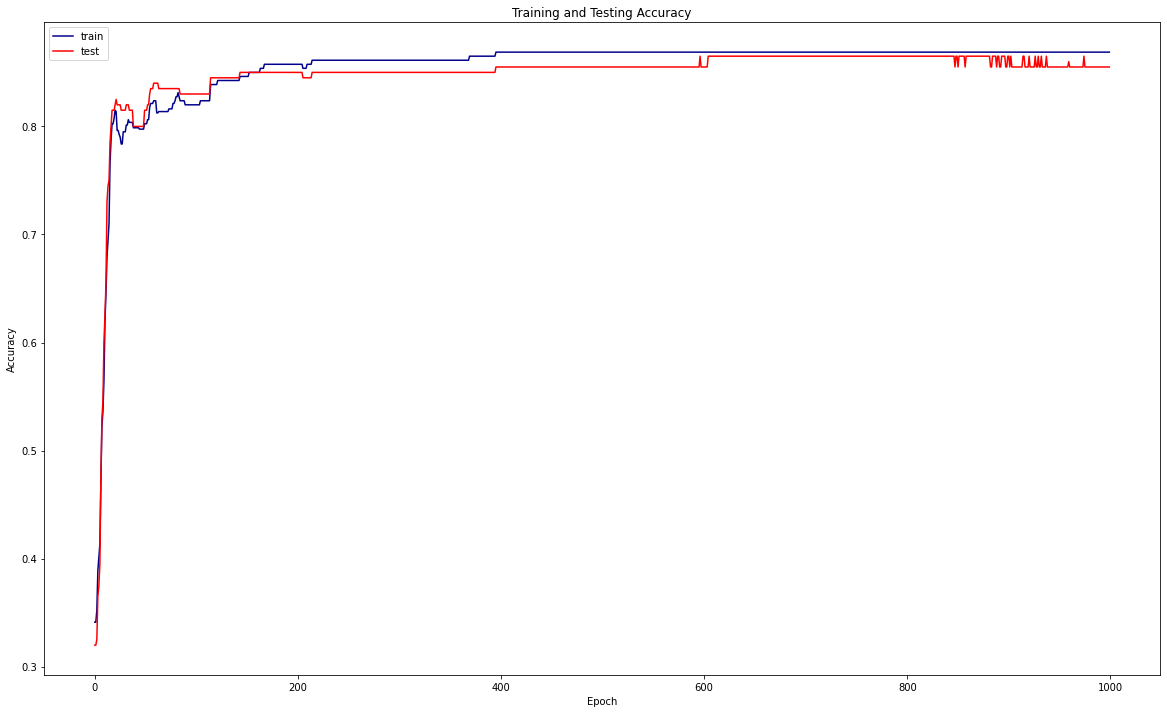

In [66]:


X = data.iloc[:, 1:-1].values
y = data.iloc[:, -1].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# Обучение модели
train_accs = []
test_accs = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
for epoch in range(1000):
    optimizer.zero_grad()
    output = net(torch.tensor(X_train, dtype=torch.float))
    loss = criterion(output, torch.tensor(y_train, dtype=torch.long))
    loss.backward()
    optimizer.step()

    # Оценка точности модели на обучающей и тестовой выборках на каждой эпохе
    with torch.no_grad():
        train_pred = torch.argmax(net(torch.tensor(X_train, dtype=torch.float)), dim=1).numpy()
        train_acc = accuracy_score(y_train, train_pred)
        train_accs.append(train_acc)
        
        test_pred = torch.argmax(net(torch.tensor(X_test, dtype=torch.float)), dim=1).numpy()
        test_acc = accuracy_score(y_test, test_pred)
        test_accs.append(test_acc)

# Оценка модели
y_pred = torch.argmax(net(torch.tensor(X_test, dtype=torch.float)), dim=1).numpy()
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))


# График точности на обучающей и тестовой выборках по каждой эпохе
plt.figure(figsize=(20,12))
plt.plot(range(len(train_accs)), train_accs, label='train', color="darkblue")
plt.plot(range(len(test_accs)), test_accs, label='test', color="red")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


In [67]:
import numpy as np

new_data = np.array([
    [0, 1, 0, 1, 1, 0, 1],  # MEMORY
    [1, 0, 1, 0, 0, 1, 0],  # DATABASE_ISSUE
    [0, 0, 1, 0, 1, 1, 0],  # NETWORK_DELAY
    [0, 1, 0, 1, 0, 1, 0]   # MEMORY
])

# Применение модели к новым данным
y_pred = torch.argmax(net(torch.tensor(new_data, dtype=torch.float)), dim=1).numpy()
y_pred = le.inverse_transform(y_pred)
print(y_pred)

# Применение модели к новым данным и вывод вероятностей предсказаний
y_pred_prob = torch.softmax(net(torch.tensor(new_data, dtype=torch.float)), dim=1).detach().numpy()
print(y_pred_prob)

def MyPrint(y_pred, y_pred_prob):
    for i in range(len(y_pred)):
        print(f'Для {i + 1} строки ROOT_CAUSE является {y_pred[i]} с вероятностью {round(max(y_pred_prob[i])*100, 2)}%')

MyPrint(y_pred, y_pred_prob)

['MEMORY' 'DATABASE_ISSUE' 'NETWORK_DELAY' 'MEMORY']
[[4.0629844e-04 9.9749351e-01 2.1002158e-03]
 [7.8817779e-01 1.5693420e-08 2.1182214e-01]
 [4.1873469e-03 3.3890072e-07 9.9581224e-01]
 [2.6793973e-04 9.9209130e-01 7.6407040e-03]]
Для 1 строки ROOT_CAUSE является MEMORY с вероятностью 99.75%
Для 2 строки ROOT_CAUSE является DATABASE_ISSUE с вероятностью 78.82%
Для 3 строки ROOT_CAUSE является NETWORK_DELAY с вероятностью 99.58%
Для 4 строки ROOT_CAUSE является MEMORY с вероятностью 99.21%
